In [1]:
pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.4/332.4 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 30.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-macos 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.8.0 which is incompatible.

[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: /Users/pragatpagariya/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
import pandas as pd
from sklearn.metrics import roc_curve, auc

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In the below cell ImageDataGenerator, is used to preprocess images and apply data augmentation to increase the variety of training images. 
The rescale function normalizes the pixel values of the images in one format for further development of model as different images size can not be processed together. 
The shear range applies a shear transformation (tilting the image like a parallelogram) by up to 20% of the image.
The zoom range randomly zooms in on images by up to 20%.
The fill model is important as when transformations like zooming or shearing change the shape of the image, new pixels need to be filled.

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode="nearest")
training_set = train_datagen.flow_from_directory('/Users/pragatpagariya/Desktop/apziva/4/images/training',
                                                 target_size = (100, 100),
                                                 batch_size = 64,
                                                 class_mode = 'binary'
                                                 )

Found 2392 images belonging to 2 classes.


Same pre processing is done for testing images also

In [6]:
test_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                  fill_mode="nearest")
test_set = test_datagen.flow_from_directory('/Users/pragatpagariya/Desktop/apziva/4/images/testing',
                                            target_size = (100, 100),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            shuffle = False)

Found 597 images belonging to 2 classes.


In the below cell I have derived the classes and initialized them as 0 and 1

In [7]:
class_name_train = training_set.class_indices
print(class_name_train)
class_name_test = test_set.class_indices
print(class_name_test)

{'flip': 0, 'notflip': 1}
{'flip': 0, 'notflip': 1}


In [8]:
for image_batch, labels_batch in training_set:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 100, 100, 3)
(64,)


In [9]:
print(class_name_test.values())

dict_values([0, 1])


Building a CNN model 
Initialising the CNN

In [10]:
cnn = tf.keras.models.Sequential()

In [11]:
cnn.dtype

'float32'

I have made a Convolutional Nueral Network Model below and provided a summary at last. 

In the below layer there are 32 filters as a feature detectors. 
Each filter is a 4x4 matrix as there kernel size is 4. 
I have used Uses ReLU (Rectified Linear Unit) activation function, which introduces non-linearity and helps avoid vanishing gradient issues.
The input images are 100x100 pixels with 3 color channels (RGB).

In [12]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=4, activation='relu', input_shape=[100, 100, 3]))

/Users/pragatpagariya/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Added second Convolutional Layer and Pooling layer 
MaxPooling layers reduce dimensions, preventing overfitting and improving efficiency.

In [13]:
cnn.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100,100,3)))
cnn.add(tf.keras.layers.MaxPool2D((3,3)))
cnn.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D((3,3)))
cnn.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D((3,3)))

Flatten layer converts 2D images into 1D vectors 
In dense layer the units are known as nuerins, wherein 256 nueron have been defined and 

In [14]:
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=256, activation='relu'))

In [15]:
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [16]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 97, 97, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 95, 95, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 234,753 (917.00 KB)

 Trainable params: 234,753 (917.00 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [19]:
print(cnn.output_shape)

print(cnn.input_shape)

(None, 1)
(None, 100, 100, 3)


In [20]:
history = cnn.fit(x = training_set, validation_data = test_set, epochs = 25, batch_size= 25)

/Users/pragatpagariya/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - binary_accuracy: 0.4939 - loss: 0.6940 - val_binary_accuracy: 0.5142 - val_loss: 0.6914
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - binary_accuracy: 0.5727 - loss: 0.6831 - val_binary_accuracy: 0.6097 - val_loss: 0.6594
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - binary_accuracy: 0.6297 - loss: 0.6590 - val_binary_accuracy: 0.7253 - val_loss: 0.5877
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - binary_accuracy: 0.7526 - loss: 0.5692 - val_binary_accuracy: 0.8174 - val_loss: 0.4670
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - binary_accuracy: 0.8026 - loss: 0.4528 - val_binary_accuracy: 0.8224 - val_loss: 0.4105
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - binary_accuracy: 0.8351 - loss: 0.3923 - val_binary_accuracy: 0.8576 - val_loss: 0.3301
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - binary_accuracy: 0.8588 - loss: 0.3334 - val_binary_accuracy: 0.8911 - val_loss: 0.2758
Epoch 8/25
38/38 ━━━

In the below cell I have given the chart of training and validation loss and accuracy. 
Training accuracy measures how well the model performs on the training dataset. It increases as the model learns patterns from the data, and validation accuracy measures how well the model generalizes to unseen data (validation set). If it’s much lower than training accuracy, the model might be overfitting.
Training loss measures how far the predicted outputs are from the actual labels. It should decrease as the model learns, and validation loss Measures error on the validation set. If validation loss increases while training loss decreases, it indicates overfitting.

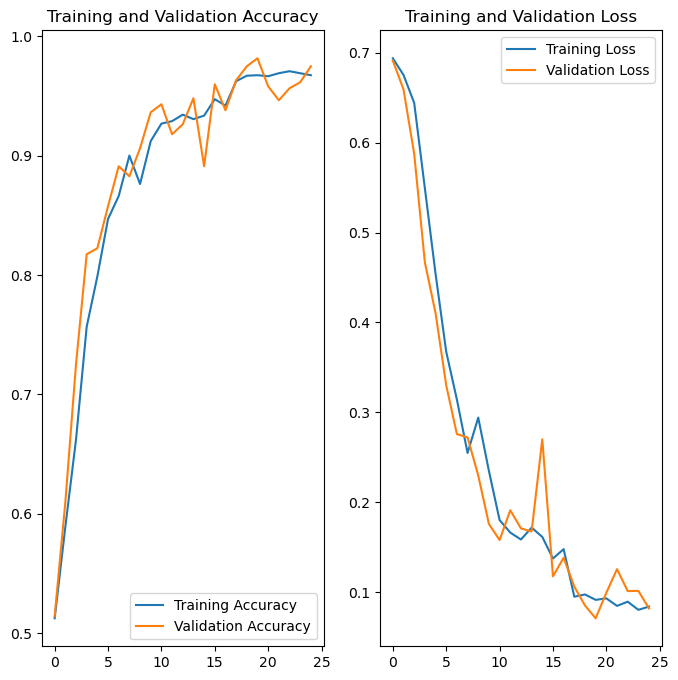

In [21]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
cnn.evaluate(test_set)

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 466ms/step - binary_accuracy: 0.9683 - loss: 0.0534


[0.06878149509429932, 0.9648241400718689]

In [23]:
y_pred = cnn.predict(test_set)

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step


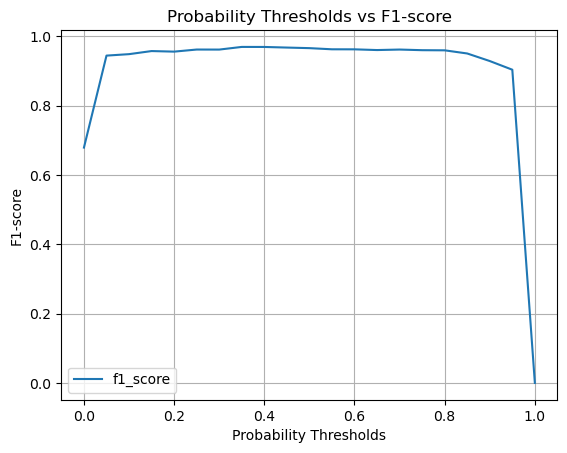

In [24]:
thresholds = np.arange(21)*0.05
f1 = []

for thres in thresholds:
    y_predics = np.where(y_pred > thres, 1, 0)
    f1.append(f1_score(test_set.classes, y_predics))

plt.figure()
plt.plot(thresholds, f1, label='f1_score')
plt.xlabel('Probability Thresholds')
plt.ylabel('F1-score')
plt.title('Probability Thresholds vs F1-score')
plt.legend()
plt.grid()
plt.show()


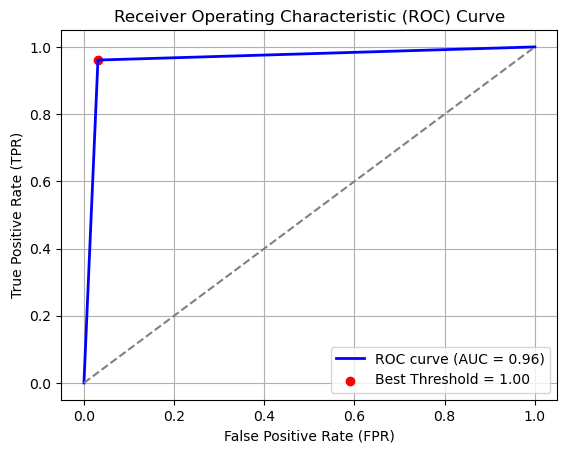

Best Threshold: 1.00


In [30]:
fpr, tpr, thresholds = roc_curve(test_set.classes, y_pred)
roc_auc = auc(fpr, tpr)

# Compute Youden's J statistic to find the best threshold
J_scores = tpr - fpr
best_index = np.argmax(J_scores)  # Index of the best threshold
best_threshold = thresholds[best_index]

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.scatter(fpr[best_index], tpr[best_index], color='red', marker='o', label=f'Best Threshold = {best_threshold:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Print best threshold
print(f'Best Threshold: {best_threshold:.2f}')


In [27]:
y_true = []
y_pred = []

for i in range(len(test_set)):
    x, y = next(test_set)
    y_true.extend(y)
    preds = cnn.predict(x)
    y_pred.extend(preds.squeeze())

y_true = np.array(y_true)
y_pred = (np.array(y_pred) >= 0.5).astype(int)

class_names = ['notflip', 'flip']

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
              precision    recall  f1-score   support

     notflip       0.96      0.97      0.96       290
        flip       0.97      0.96      0.97       307

    accuracy                           0.96       597
   macro avg       0.96      0.96      0.96       597
weight

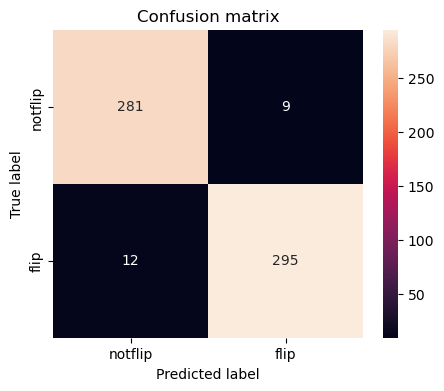

In [28]:
import seaborn as sns


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

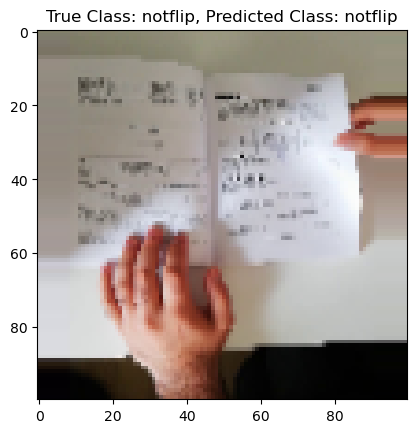

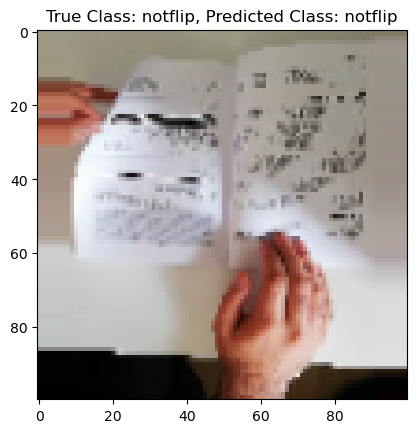

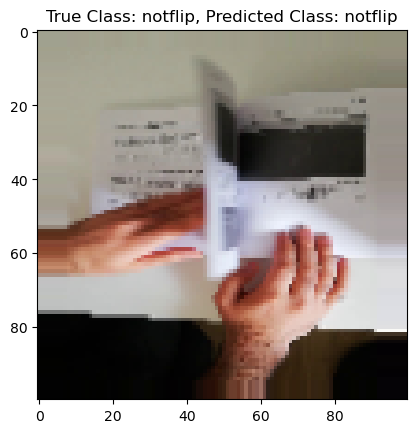

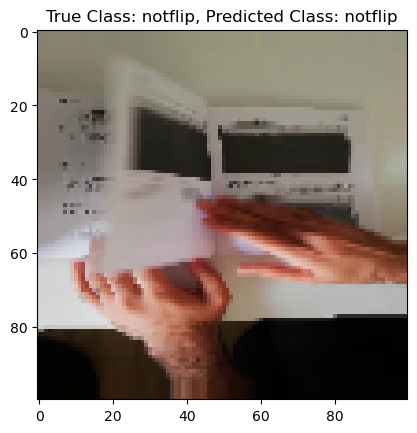

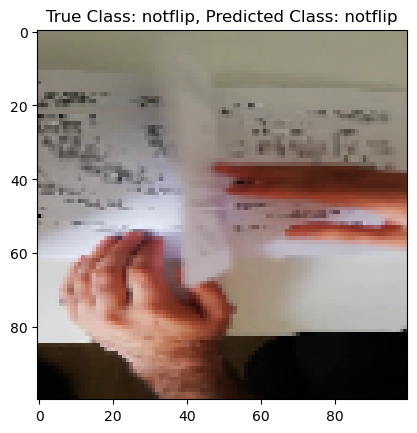

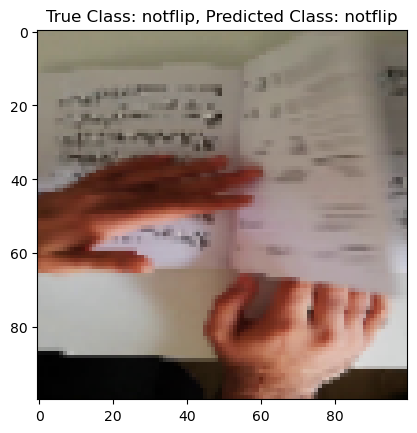

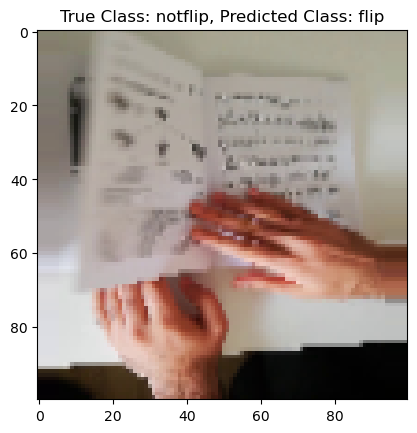

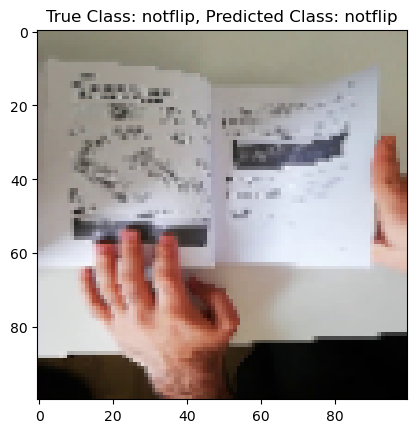

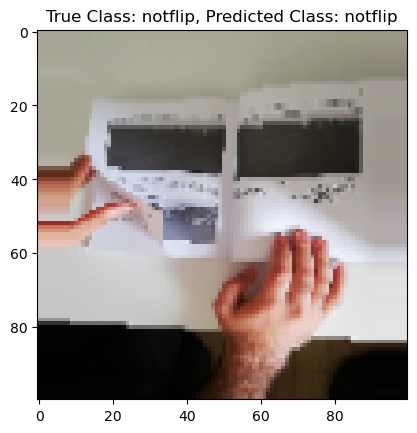

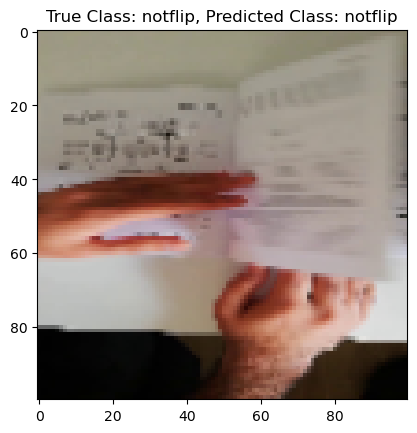

In [29]:
x, y = next(test_set)
images = x
labels = y

indices = np.random.choice(len(images), size=10, replace=False)
for idx in indices:
    true_class = class_names[int(labels[idx])]
    pred_class = class_names[int(y_pred[idx])]

    plt.imshow(images[idx])
    plt.title(f"True Class: {true_class}, Predicted Class: {pred_class}")
    plt.show()